In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

In [2]:
data = xr.open_dataset("./data/ssta_1950_2021.nc")['ssta']

print("Data shape: {}".format(data.shape))
print("Data : {}".format(data))

Data shape: (864, 13, 35)
Data : <xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...


In [3]:
# Use Principal Component Analysis to reduce the dimensionality of the data

pca_5 = ut.SpatioTemporalPCA(data, n_components=5)
pca_10 = ut.SpatioTemporalPCA(data, n_components=10)
pca_15 = ut.SpatioTemporalPCA(data, n_components=15)

print("Explained variance ratio for 5 components: {}".format(np.sum(pca_5.explained_variance())))
print("Explained variance ratio for 10 components: {}".format(np.sum(pca_10.explained_variance())))
print("Explained variance ratio for 15 components: {}".format(np.sum(pca_15.explained_variance())))

eof_5 = pca_5.eofs()
eof_10 = pca_10.eofs()
eof_15 = pca_15.eofs()

print("EOFs shape for 5 components: (eof, lat, lon) {}".format(eof_5.shape))
print("EOFs shape for 10 components: (eof, lat, lon) {}".format(eof_10.shape))
print("EOFs shape for 15 components: (eof, lat, lon) {}".format(eof_15.shape))

pc_5 = pca_5.principal_components()
pc_10 = pca_10.principal_components()
pc_15 = pca_15.principal_components()

print("PCs shape for 5 components: (eof, time) {}".format(pc_5.shape))
print("PCs data for 5 components: {}".format(pc_5))
print("PCs shape for 10 components: (eof, time) {}".format(pc_10.shape))
print("PCs shape for 15 components: (eof, time) {}".format(pc_15.shape))


Explained variance ratio for 5 components: 0.5822137847822122
Explained variance ratio for 10 components: 0.7008253195143397
Explained variance ratio for 15 components: 0.7601915732214221
EOFs shape for 5 components: (eof, lat, lon) (5, 13, 35)
EOFs shape for 10 components: (eof, lat, lon) (10, 13, 35)
EOFs shape for 15 components: (eof, lat, lon) (15, 13, 35)
PCs shape for 5 components: (eof, time) (5, 864)
PCs data for 5 components: <xarray.DataArray (eof: 5, time: 864)>
array([[ -6.29767607,  -6.92623833,  -6.06612333, ...,  -8.78229121,
        -10.73037298, -11.51841333],
       [ -1.32017406,  -0.94989201,  -0.177297  , ...,   3.58378555,
          3.30997505,   0.36169668],
       [ -2.06665382,  -2.59613487,  -2.82771543, ...,  -3.41827008,
         -4.84755497,  -4.01489698],
       [  0.20367338,   0.5355141 ,  -0.37873088, ...,  -1.01850882,
         -0.44631813,  -1.55271434],
       [ -0.18499822,   1.66551362,   1.91978303, ...,  -0.80694695,
          0.88235572,   1.137

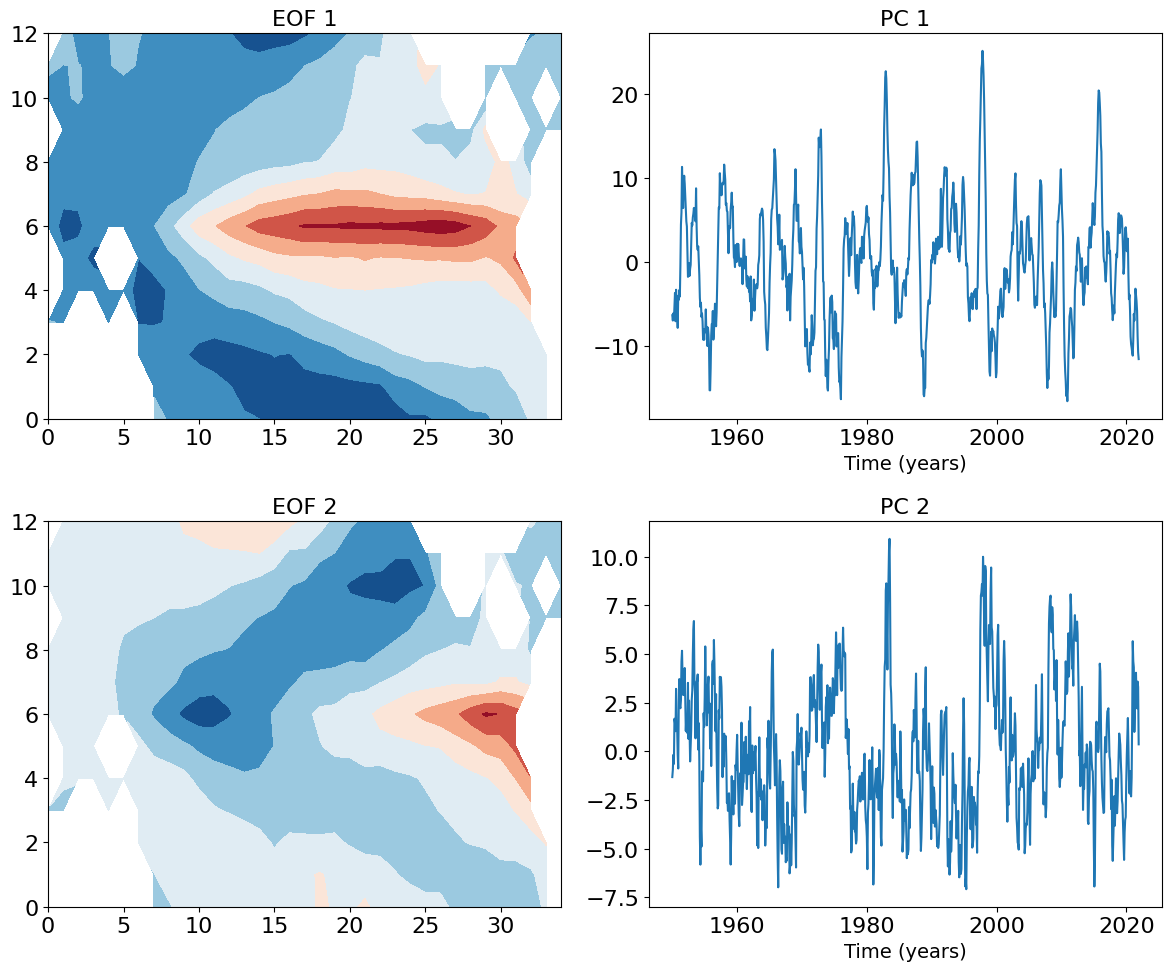

In [4]:
# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=16)
    axs[i,0].contourf(eof_10[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=16)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_10[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=14)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)

In [5]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

In [6]:
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)
print("Data train : {} + shape: {}".format(data_train.data, data_train.data.shape))

Frobenius norm: 0.7287985917647677
Data train : [[-6.29767607 -6.92623833 -6.06612333 ... -5.33055296 -4.86835222
  -6.0603949 ]
 [-1.32017403 -0.94989195 -0.17729696 ... -2.09860531 -2.16949402
  -2.62321542]
 [-2.06665348 -2.59613492 -2.82771561 ... -1.22104009 -2.50958123
  -1.09307038]
 ...
 [ 0.46673104  0.63499592  0.63568842 ... -5.22359474 -5.79775285
  -3.26079795]
 [ 1.10667796  0.45420989  0.14109366 ...  1.62802257 -0.17278895
   1.00873791]
 [ 1.58693338  1.44656106  2.32706288 ... -0.99464946 -0.78740408
  -0.79309173]] + shape: (10, 691)


In [7]:
# Model geometric brownian motion

#model.geometric_brownian_motion(mu=2)


In [8]:
# Numerical integration of stochastic process using euler_maruyama method
#model.euler_maruyama(input_data)

In [9]:
# Simulate stochastic differential equation
# Input: Y0, L, Q, T, dt
x_input = data_test.isel(time=0)
times = x_input['time']
x = x_input.data

#model.euler_maruyama(x, 100, 2)
#forecast_output, forecast_output2 = model.forecast(x, [1,2,3])
output_array, state_mid = model.noise_integration(x, [1,2,3], timesteps=3)

#model.simulate_sde(x, 100, 2)

Output at timestep 0 is [[-8.07864818 -3.14451958 -2.26565644 -0.64083883 -2.02679798 -0.41761334
   2.07481546 -0.93319094 -0.64450734 -1.3867074 ]
 [-7.4884562  -3.01144981 -0.13145425  0.44182276 -3.00385871 -1.8345104
   0.45900694 -1.49532062  1.32871    -1.57576557]
 [-7.94291376 -3.33571857 -2.98427727 -0.7414933  -1.95418486 -0.16633761
   2.15353431 -1.51446867 -1.3718569  -1.5256101 ]
 [-8.210565   -3.34128074 -2.07368375 -0.73890592 -2.05708001 -0.42813899
   2.05490262 -0.94961729 -0.79219217 -1.29353695]
 [-8.19695732 -3.53696248 -1.96624403 -0.78510754 -2.00901704 -0.36499896
   2.10692232 -0.97413558 -0.8116691  -1.29449925]
 [-8.75021762 -3.83773603 -1.77366654 -0.09153102 -2.39735854 -0.14944422
   2.43542977 -1.06961218 -0.51228515 -1.25154814]
 [-8.40996387 -2.98580699 -1.99964245 -0.69869416 -2.10944438 -0.59187395
   1.31713331 -1.10967755 -0.44813309 -1.67247176]
 [-8.21312701 -3.61859819 -2.21147727 -0.55328143 -1.53497325 -0.19251371
   1.5843816  -0.85906945 -0

In [10]:
#Create forecast with LIM using forecast lag

lag = 2

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data
# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

print("Forecasting mean using LIM model : {}".format(x_frcst))

G_tau: [[ 8.98459541e-01+1.14993631e-17j -1.23934792e-02-4.03150073e-18j
   1.60069346e-01-2.55738309e-18j -2.12293086e-01+1.70975431e-17j
   4.91796090e-01-2.08453652e-18j -3.53695555e-01-3.94342043e-17j
  -3.90548451e-02-1.84123037e-17j  2.91363603e-01+4.47403203e-17j
   7.53860093e-02+6.69445196e-18j  1.33258431e-01-4.32131206e-18j]
 [-6.00764254e-03+1.20059356e-17j  7.83186717e-01+1.72744345e-17j
   3.02697499e-02+1.40353914e-18j -5.69845319e-02+2.26737322e-19j
   1.19330929e-01-2.10239005e-17j -5.45272855e-02+3.91068485e-17j
  -5.01523201e-02+5.53379526e-18j -4.36912835e-03-5.22611397e-18j
  -5.52940772e-02+1.66537043e-17j  5.30499235e-02-1.33920439e-18j]
 [-1.90538793e-02-2.64889216e-19j  3.82388826e-02-3.83855347e-19j
   7.80949399e-01-1.18000122e-17j -4.29596385e-02+1.41327873e-17j
  -1.12766109e-01+3.48773353e-17j -2.59806270e-02+1.57733707e-17j
   1.36191907e-02-8.56762020e-18j  1.71167776e-02+2.70988011e-17j
  -1.80516379e-01+1.87801733e-17j  1.58672004e-02+8.53592068e-18j]


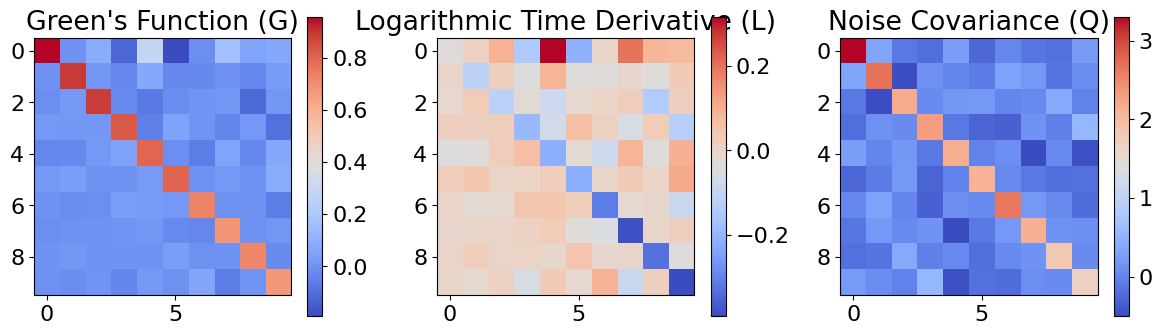

In [11]:
# Plot G, L, Q
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

# Plot G
im1 = axs[0].imshow(model.green_function, cmap='coolwarm')
axs[0].set_title('Green\'s Function (G)')
fig.colorbar(im1, ax=axs[0])

# Plot L
im2 = axs[1].imshow(np.real(model.logarithmic_matrix), cmap='coolwarm')
axs[1].set_title('Logarithmic Time Derivative (L)')
fig.colorbar(im2, ax=axs[1])

# Plot Q
im3 = axs[2].imshow(np.real(model.noise_covariance), cmap='coolwarm')
axs[2].set_title('Noise Covariance (Q)')
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()

G_tau: [[ 0.82682412-2.43999606e-18j -0.03664138-5.52624723e-18j
   0.22484819+2.61831322e-17j -0.26984674+1.95280473e-17j
   0.64160603+7.75120856e-20j -0.48209513+3.45902602e-17j
  -0.06980976-8.15062607e-18j  0.37307661+2.18575654e-17j
   0.06921387-5.67281253e-18j  0.18440578-1.44785815e-17j]
 [-0.01367645+1.39940395e-17j  0.6882813 +1.27165664e-17j
   0.04132328-5.21191229e-18j -0.07149184+5.02053803e-18j
   0.14869665+1.03304966e-17j -0.07387812+1.15503836e-17j
  -0.06288635-4.38443480e-18j -0.00245979+5.14695371e-18j
  -0.07229153-2.87027836e-18j  0.07152234-1.91088821e-18j]
 [-0.02466547+3.56077968e-18j  0.04915488-4.84118223e-19j
   0.68742885-2.52621636e-17j -0.05873688+1.85840803e-18j
  -0.14175051-3.51756257e-18j -0.03608747+1.59723584e-17j
   0.02180781+9.50830595e-18j  0.01352521+9.33942954e-18j
  -0.21776347-4.76589684e-18j  0.01678368+1.78572629e-17j]
 [ 0.05406253+5.75156368e-18j  0.04787502-5.33041994e-18j
   0.03814173-5.05945257e-18j  0.55218137-5.16148502e-18j
  -0

Text(0.5, 0, 'Time')

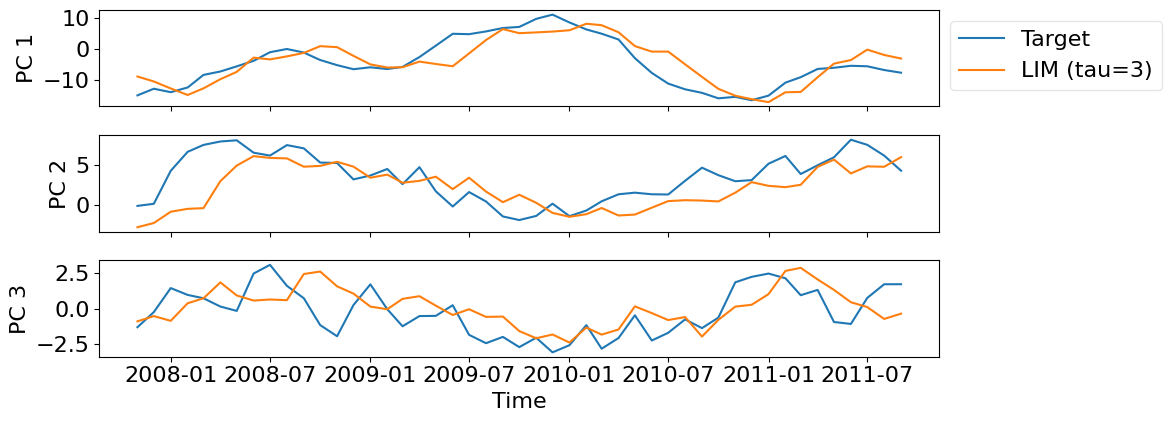

In [12]:
# Forecasting

# Define lag
lag = 3

# Get input data
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data

# Forecast mean using LIM model
x_frcst = model.forecast_mean(x, lag=lag)

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(12, len(idx_components)*1.5), sharex=True)

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], x_frcst[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {component+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')

Reconstructed input data shape: (47, 13, 35)
Reconstructed forecast data shape: (47, 13, 35)


Text(0.5, 1.0, 'Forecast')

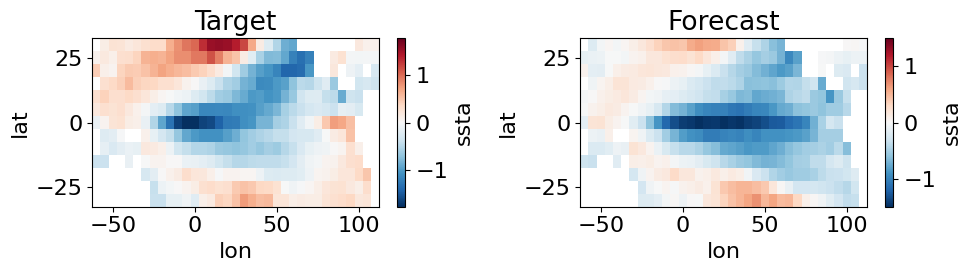

In [13]:
# Transform back to data space (denoted with y) and plot the time evolution of selected components

# Reconstruct the input and forecasted data
reconstructed_input = pca_10.reconstruction(x[:, lag:], newdim=times[lag:])
reconstructed_forecast = pca_10.reconstruction(x_frcst[:, :-lag], newdim=times[lag:])

print(f"Reconstructed input data shape: {reconstructed_input.shape}")
print(f"Reconstructed forecast data shape: {reconstructed_forecast.shape}")

# Choose a time index to plot
time_index = 5

# Define plot parameters
plot_params = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
               'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

# Plot the input and forecasted data at the chosen time index
fig, axs = plt.subplots(1,2, figsize=(10, 3))
reconstructed_input.isel(time=time_index).plot(ax=axs[0])
axs[0].set_title("Target")
reconstructed_forecast.isel(time=time_index).plot(ax=axs[1])
axs[1].set_title("Forecast")